In [1]:
import json
import os
import sys
import math
import datetime
import pathlib
import numpy as np

dir_path = pathlib.Path(os.path.abspath('')).resolve()
print(dir_path)
HOME_DIR = str(dir_path).split('/OpenFormat-Public')[0]

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

PROJ_SRC_DIR = f'{HOME_DIR}/OpenFormat-Public'
sys.path.insert(1, f'{PROJ_SRC_DIR}')
from python.scripts.utils import *
num_rows = 1000 * 1000
num_cols = 20
workload_list = ['core', 'geo', 'classic', 'log', 'ml', 'bi']

/home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/python/general


In [2]:
HOME_DIR = str(dir_path).split('/OpenFormat')[0]
scan_exec_pq = f'{HOME_DIR}/arrow-private/arrow-Public/cpp/out/build/openformat-release-static/release/parquet-scan-columnbatch'

# Predefined workloads, size and scan time

In [3]:
%%time
# generate csv files
os.chdir(f'{PROJ_SRC_DIR}/benchmark/generator_v2')
!pwd
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    os.system(f'python3 gen_workloads.py \
        {wl} {num_rows} {num_cols} {base_name}')
    os.system(f'cp -r {base_name} {dir_path} && \
        rm -r {base_name}')
os.chdir(dir_path)
!pwd

/home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/benchmark/generator_v2
Finish core dataset! 🎉🎉🎉🎉🎉🎉
Generating Done!!
Finish workload: geo! 🎉🎉🎉🎉🎉🎉
Generating Done!!
Finish workload: classic! 🎉🎉🎉🎉🎉🎉
Generating Done!!
🤔 INFO: too many collisions in int_unique_list, 19734 values just use (max_value + 1)!
🤔 INFO: too many collisions in int_unique_list, 342213 values just use (max_value + 1)!
Finish workload: log! 🎉🎉🎉🎉🎉🎉
Generating Done!!
Finish workload: ml! 🎉🎉🎉🎉🎉🎉
Generating Done!!
🤔 INFO: too many collisions in int_unique_list, 7 values just use (max_value + 1)!
Finish workload: bi! 🎉🎉🎉🎉🎉🎉
Generating Done!!
/home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/python/general
CPU times: user 28.9 ms, sys: 19.1 ms, total: 48 ms
Wall time: 12min 19s


In [45]:
pq_config = enumerate_config(f'{PROJ_SRC_DIR}/python/experiments/pq_plain.json')
orc_config = enumerate_config(f'{PROJ_SRC_DIR}/python/experiments/orc_plain.json')
pq_name_suffix = '_' + "_".join([str(i) for i in list(pq_config[0].values())]) + '.parquet'
orc_name_suffix = '_' + "_".join([str(i) for i in list(orc_config[0].values())]) + '.orc'
print(pq_name_suffix)
print(orc_name_suffix)
print(pq_config)
print(orc_config)

loading config from /home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/python/experiments/pq_plain.json ...
loading config from /home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/python/experiments/orc_plain.json ...
_NONE_False_1048576_2.6_2.0.parquet
_UNCOMPRESSED_speed_0.orc
[{'compression': 'NONE', 'use_dictionary': False, 'row_group_size': 1048576, 'version': '2.6', 'data_page_version': '2.0'}]
[{'compression': 'UNCOMPRESSED', 'compression_strategy': 'speed', 'dictionary_key_size_threshold': 0}]


## BtrBlocks files

In [5]:
# create btrblock schema file
import yaml
os.chdir(f'{PROJ_SRC_DIR}/python')
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    arrow_schema_name = f'general/{base_name}/gen_data/{base_name}_arrow_schema.txt'
    with open(arrow_schema_name, 'r') as f:
        lines = f.readlines()
    columns = []
    cnt = 0
    for line in lines:
        if 'message' in line or '}' in line or len(line)==0:
            print(line)
            continue
        col_name = f'col{cnt}'
        col_type = None
        if 'String' in line:
            col_type = 'string'
        elif 'int' in line:
            col_type = 'integer'
        elif 'double' in line:
            col_type = 'double'
        if col_type is None:
            print(line)
            col_type = 'skip'
        cnt += 1
        columns.append({'name': col_name, 'type':col_type})
    with open(f'general/{base_name}/gen_data/{base_name}_btrblocks_schema.yaml','w') as f:
        yaml.dump({'columns':columns}, f)

message schema {

}
message schema {

}
message schema {

}
message schema {

}
message schema {

}
message schema {

}


In [46]:
os.chdir(f'{PROJ_SRC_DIR}/python')
my_password = ""
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    print(base_name)
    os.system(f'cp general/{base_name}/gen_data/{base_name}.csv data_gen')
    os.system(f'echo {my_password} | sudo -S /home/haoyuq/miniconda3/envs/gen/bin/python scripts/parquet_exp.py {base_name} pq_plain -r=false -o=false')
    os.system(f'echo {my_password} | sudo -S /home/haoyuq/miniconda3/envs/gen/bin/python scripts/orc_exp.py {base_name} orc_plain -r=false -o=false')
    os.system(f'mv {base_name}{pq_name_suffix} general/{base_name}{pq_name_suffix}.parquet')
    os.system(f'mv {base_name}{orc_name_suffix} general/{base_name}{orc_name_suffix}.orc')
os.chdir(f'{PROJ_SRC_DIR}/python/general')

core_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.47096872329711914


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.7955284118652344
geo_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.5635099411010742


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.9063608646392822
classic_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.6187753677368164


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 1.0068562030792236
log_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.5352048873901367


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.8383834362030029
ml_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.5402238368988037


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.955223560333252
bi_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.4400486946105957


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.7259507179260254


In [8]:
# generating files for btrblocks
os.chdir(f'{PROJ_SRC_DIR}/python')
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    os.system(f'mkdir general/{base_name}/gen_data/binary')
    os.system(f'mkdir general/{base_name}/gen_data/btr')
    
    os.system(f'~/btrblocks/build/csvtobtr -create_binary -binary general/{base_name}/gen_data/binary/ -csv general/{base_name}/gen_data/{base_name}.csv -yaml general/{base_name}/gen_data/{base_name}_btrblocks_schema.yaml')
    os.system(f'~/btrblocks/build/csvtobtr -create_btr -btr general/{base_name}/gen_data/btr/ -binary general/{base_name}/gen_data/binary/ -csv general/{base_name}/gen_data/{base_name}.csv -yaml general/{base_name}/gen_data/{base_name}_btrblocks_schema.yaml')
os.chdir(f'{PROJ_SRC_DIR}/python/general')

mkdir: cannot create directory ‘general/core_r1000000_c20/gen_data/binary’: File exists
mkdir: cannot create directory ‘general/core_r1000000_c20/gen_data/btr’: File exists


[2024-03-06 03:43:39.155] [info] Creating binary files in general/core_r1000000_c20/gen_data/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = integer
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/core_r1000000_c20/gen_data/binary/1_col0.bitmap
Writing binary file : general/core_r1000000_c20/gen_data/binary/1_col0.bitmap
[haoyu.

mkdir: cannot create directory ‘general/geo_r1000000_c20/gen_data/binary’: File exists
mkdir: cannot create directory ‘general/geo_r1000000_c20/gen_data/btr’: File exists


[2024-03-06 03:43:55.301] [info] Creating binary files in general/geo_r1000000_c20/gen_data/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/binary/1_col0.bitmap
Writing binary file : general/geo_r1000000_c20/gen_data/binary/1_col0.bitmap
[haoyu.debu

mkdir: cannot create directory ‘general/classic_r1000000_c20/gen_data/binary’: File exists
mkdir: cannot create directory ‘general/classic_r1000000_c20/gen_data/btr’: File exists


[2024-03-06 03:44:17.966] [info] Creating binary files in general/classic_r1000000_c20/gen_data/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/binary/1_col0.bitmap
Writing binary file : general/classic_r1000000_c20/gen_data/binary/1_col0.bitmap

mkdir: cannot create directory ‘general/log_r1000000_c20/gen_data/binary’: File exists
mkdir: cannot create directory ‘general/log_r1000000_c20/gen_data/btr’: File exists


[2024-03-06 03:44:44.910] [info] Creating binary files in general/log_r1000000_c20/gen_data/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/binary/1_col0.bitmap
Writing binary file : general/log_r1000000_c20/gen_data/binary/1_col0.bitmap
[haoyu.debug.

mkdir: cannot create directory ‘general/ml_r1000000_c20/gen_data/binary’: File exists
mkdir: cannot create directory ‘general/ml_r1000000_c20/gen_data/btr’: File exists


[2024-03-06 03:45:04.536] [info] Creating binary files in general/ml_r1000000_c20/gen_data/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/binary/1_col0.bitmap
Writing binary file : general/ml_r1000000_c20/gen_data/binary/1_col0.bitmap
[haoyu.debug.wri

mkdir: cannot create directory ‘general/bi_r1000000_c20/gen_data/binary’: File exists
mkdir: cannot create directory ‘general/bi_r1000000_c20/gen_data/btr’: File exists


[2024-03-06 03:45:25.777] [info] Creating binary files in general/bi_r1000000_c20/gen_data/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = integer
column name = col8 , type = integer
column name = col9 , type = integer
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/binary/1_col0.bitmap
Writing binary file : general/bi_r1000000_c20/gen_data/binary/1_col0.bitmap
[haoyu.debu

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.


In [4]:
# read_metadata
os.chdir(f'{PROJ_SRC_DIR}/python')
name = 'btrmetas_chunk_threshold_16MB'
os.system(f'mkdir general/{name}')
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    os.system(f'~/btrblocks/build/btrmeta -btr general/{base_name}/gen_data/btr/ >> general/{name}/{base_name}_trace.txt')    

In [47]:
# running experiments
os.chdir(f'{PROJ_SRC_DIR}/python/general')
os.system('rm outputs/stats.json')
my_password = ""
for i in range(10):
    for wl in workload_list:
        base_name = f'{wl}_r{num_rows}_c{num_cols}'
        os.system(f'echo {my_password} | sudo -S sync; echo {my_password} | sudo sh -c "/usr/bin/echo 3 > /proc/sys/vm/drop_caches"')
        time.sleep(1)
        pq_read = float(os.popen(f'''{scan_exec_pq} \
                --batch_size=1024 ./{base_name}{pq_name_suffix}.parquet''').read().split('\n')[0].split(' ')[-2])
        os.system(f'echo {my_password} | sudo -S sync; echo {my_password} | sudo sh -c "/usr/bin/echo 3 > /proc/sys/vm/drop_caches"')
        time.sleep(1)
        orc_read = float(os.popen(f'''{HOME_DIR}/orc/orc/build/tools/src/orc-scan \
                -b 1024 ./{base_name}{orc_name_suffix}.orc''').read().split('\n')[0].split(' ')[-1])
        os.system(f'echo {my_password} | sudo -S sync; echo {my_password} | sudo sh -c "/usr/bin/echo 3 > /proc/sys/vm/drop_caches"')
        time.sleep(1)
        # btrblocks_out = os.popen(f'''~/btrblocks/build/decompression-speed -output_summary \
        #             -btr ./{base_name}/gen_data/btr/ -threads 1''').read().split('\n')[-2],
        btrblocks_out = os.popen(f'''~/btrblocks/build/decompression-speed -output_summary \
                    -btr ./{base_name}/gen_data/btr/ -threads 1''').read()
        # with open(f'{name}/{base_name}_res.txt', 'w') as f:
        #     f.write(btrblocks_out)
        btrblocks_out = btrblocks_out.split('\n')[-2]
        print(btrblocks_out)
        btrblocks_read = float(btrblocks_out.split(' ')[-4])
        btrblocks_size = float(btrblocks_out.split(' ')[1])
        print(btrblocks_size)
        btrblocks_size_with_metadata = btrblocks_size + os.path.getsize(f'./{base_name}/gen_data/btr/metadata')
        orc_size = os.path.getsize(f'{base_name}{orc_name_suffix}.orc')
        pq_size = os.path.getsize(f'{base_name}{pq_name_suffix}.parquet')
        output_stats = {}
        output_stats['workload'] = wl
        output_stats['i'] = i
        output_stats['file'] = 'parquet'
        output_stats['size'] = pq_size
        output_stats['read_time'] = pq_read
        parse_output(output_stats)
        output_stats['file'] = 'orc'
        output_stats['size'] = orc_size
        output_stats['read_time'] = orc_read
        parse_output(output_stats)
        output_stats['file'] = 'btrblocks'
        output_stats['size'] = btrblocks_size
        output_stats['read_time'] = btrblocks_read
        output_stats['size_with_metadata'] = btrblocks_size_with_metadata
        parse_output(output_stats)
collect_results()
os.system('mv outputs/stats.csv ../outputs/{}_{}.csv'.format('general_exp_uncompressed', timestamp))

[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 34427799 Bytes 92571455 Bytes 50889 us 1734.82 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 290881 us 555.374 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 506034 us 463.817 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26774157 Bytes 164382967 Bytes 50563 us 3100.45 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 162731 us 820.829 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 34140 us 3107.42 MB/s
26421427.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 34427799 Bytes 92571455 Bytes 50936 us 1733.21 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 290559 us 555.989 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 506798 us 463.118 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26774157 Bytes 164382967 Bytes 51056 us 3070.51 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 155464 us 859.198 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 33249 us 3190.69 MB/s
26421427.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 34427799 Bytes 92571455 Bytes 55375 us 1594.28 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 290818 us 555.494 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 506057 us 463.796 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26774157 Bytes 164382967 Bytes 56100 us 2794.44 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 155594 us 858.48 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 32874 us 3227.09 MB/s
26421427.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 34427799 Bytes 92571455 Bytes 50564 us 1745.97 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 290874 us 555.387 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 506301 us 463.573 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26774157 Bytes 164382967 Bytes 50791 us 3086.53 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 155432 us 859.375 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 36883 us 2876.32 MB/s
26421427.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 34427799 Bytes 92571455 Bytes 50513 us 1747.73 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 292673 us 551.973 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 506366 us 463.513 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 26774157 Bytes 164382967 Bytes 55681 us 2815.46 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 155544 us 858.756 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 33374 us 3178.74 MB/s
26421427.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 34427799 Bytes 92571455 Bytes 53617 us 1646.55 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 297592 us 542.849 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 508302 us 461.748 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26774157 Bytes 164382967 Bytes 56007 us 2799.08 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 155458 us 859.231 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 32566 us 3257.61 MB/s
26421427.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 34427799 Bytes 92571455 Bytes 50520 us 1747.49 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 290691 us 555.737 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 506407 us 463.475 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 26774157 Bytes 164382967 Bytes 55765 us 2811.22 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 155522 us 858.878 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 33142 us 3201 MB/s
26421427.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 34427799 Bytes 92571455 Bytes 54336 us 1624.76 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 291165 us 554.832 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 506368 us 463.511 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 26774157 Bytes 164382967 Bytes 56245 us 2787.23 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 155495 us 859.027 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 32327 us 3281.7 MB/s
26421427.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 34427799 Bytes 92571455 Bytes 50459 us 1749.6 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 290578 us 555.953 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 506025 us 463.825 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26774157 Bytes 164382967 Bytes 51143 us 3065.28 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 162807 us 820.446 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 32277 us 3286.78 MB/s
26421427.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 34427799 Bytes 92571455 Bytes 50282 us 1755.76 MB/s
34427799.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 117554095 Bytes 169395006 Bytes 290772 us 555.582 MB/s
117554095.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 195169406 Bytes 246108359 Bytes 506512 us 463.379 MB/s
195169406.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 26774157 Bytes 164382967 Bytes 51094 us 3068.22 MB/s
26774157.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 80388811 Bytes 140062884 Bytes 155485 us 859.082 MB/s
80388811.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: 

Total: 26421427 Bytes 111240710 Bytes 32849 us 3229.55 MB/s
26421427.0


Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


0

In [48]:
import pandas as pd
import seaborn as sns

data = pd.read_csv('../outputs/general_exp_uncompressed_20240413_200328.csv')

In [58]:
data = pd.read_csv('../outputs/general_exp_20240413_200328.csv')

In [59]:
data_avg = data.groupby(['workload','file']).mean()

In [60]:
data_avg.reset_index(inplace=True)

In [61]:
data_avg.loc[data_avg['file']=='btrblocks', 'read_time']/=1000*1000

In [57]:
import copy
data_avg2 = copy.deepcopy(data_avg)

In [62]:
data_avg['file'] = data_avg['file'].apply(lambda x: x+'_uncompressed')

In [63]:
data = pd.concat([data_avg, data_avg2])

In [67]:
data = data[data["file"] != "btrblocks_uncompressed"]

In [71]:
data

,workload,file,i,size,read_time,size_with_metadata
1,bi,orc,4.5,28144655.0,0.345579,NaN
2,bi,parquet,4.5,31206759.0,0.194650,NaN
4,classic,orc,4.5,183467312.0,0.417565,NaN
5,classic,parquet,4.5,198249209.0,0.377968,NaN
7,core,orc,4.5,38468540.0,0.368254,NaN
8,core,parquet,4.5,37413239.0,0.194494,NaN
10,geo,orc,4.5,108626537.0,0.373362,NaN
11,geo,parquet,4.5,116094986.0,0.281581,NaN
13,log,orc,4.5,17129111.0,0.250353,NaN
14,log,parquet,4.5,23909928.0,0.170915,NaN


In [81]:
def switch(x):
    if "_uncompressed" in x["file"]:
        x["file"] = x["file"].split('_uncompressed')[0]
        return x
    x["file"] = x["file"]+"_uncompressed"
    return x
data = data.apply(switch, axis=1)

In [83]:
def clean(x):
    if x=="btrblocks_uncompressed":
        return "btrblocks"
    return x
data["file"] = data["file"].apply(clean)

<Axes: xlabel='workload', ylabel='size'>

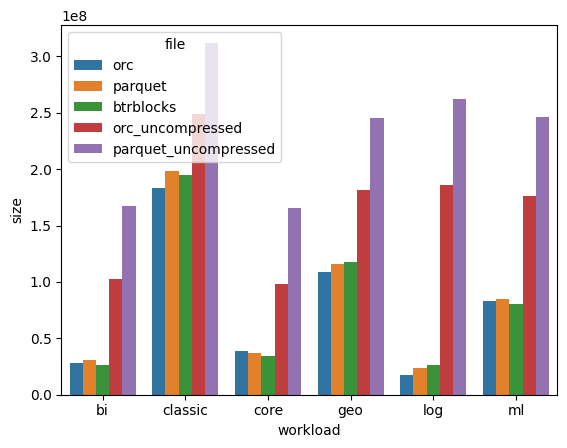

In [84]:
sns.barplot(data = data, x='workload', y='size', hue='file')

<Axes: xlabel='workload', ylabel='read_time'>

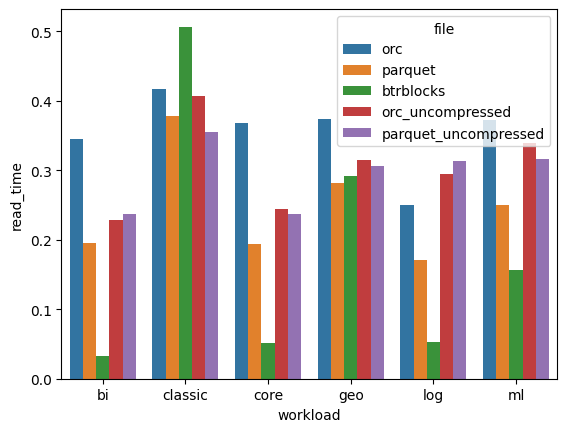

In [86]:
sns.barplot(data = data, x='workload', y='read_time', hue='file')

# Predefined workloads, filter (select)

In [ ]:
# generate filters and store in dir
os.chdir(dir_path)
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    filter_dir = f'{wl}_filters'
    os.makedirs(filter_dir, exist_ok=True)
    os.chdir(filter_dir)
    os.system(f'rm -rf point*.csv range*.csv')
    config_name = f'{PROJ_SRC_DIR}/benchmark/generator_v2/filter_config/{wl}_filter.yaml'
    os.system(f'''python3 {PROJ_SRC_DIR}/benchmark/generator_v2/filter_generator.py \
    ../{base_name}/gen_data/{base_name}.csv ../{base_name}/configs/table_config.json \
        {config_name}''')
    os.chdir(dir_path)

In [ ]:
# running experiments
import yaml
import itertools
os.system('rm outputs/stats.json')
output_stats = {}
for wl in workload_list:
    print(f'begin wl: {wl}')
    output_stats['wl'] = wl
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    filter_dir = f'{wl}_filters'
    config_name = f'{PROJ_SRC_DIR}/benchmark/generator_v2/filter_config/{wl}_filter.yaml'
    config = yaml.safe_load(open(config_name))
    config_list = config['filter_config']
    proj_type = 'one'
    for (i, fmt, config) in itertools.product(range(5), ['parquet', 'orc'], config_list):
        output_stats['format'] = fmt
        output_stats['i'] = i
        output_stats['proj_type'] = proj_type
        expectation = config.get('selectivity_expectation')
        output_stats['selectivity'] = expectation
        range_exist = True
        point_exist = True
        try:
            range_filters = pd.read_csv(f'{filter_dir}/range_{expectation}.csv')
        except:
            range_exist = False
        try:
            point_filters = pd.read_csv(f'{filter_dir}/point_{expectation}.csv')
        except:
            point_exist = False
        if range_exist:
            output_stats['filter_type'] = 'range'
            for index, row in range_filters.iterrows():
                val1 = np.int64(float(row['val1'])) if row['dtype'] == 'int' else row['val1']
                val2 = np.int64(float(row['val2'])) if row['dtype'] == 'int' else row['val2']
                os.system('sync; echo 3 > /proc/sys/vm/drop_caches')
                if fmt == 'parquet':
                    cmd = f"parquet-filterscan-noeval -f \
                        {base_name}.parquet -i {row['col_idx']} -l {val1} -r \
                            {val2} -e true"
                    output_stats['time'] = os.popen(cmd).read().split('\n')[0].split(' ')[-2]
                    output_stats['time_preload'] = os.popen(cmd).read().split('\n')[0].split(' ')[-2]
                else:
                    cmd = f"{HOME_DIR}/orc/build/c++/test/FilterExp \
                    {base_name}.orc f{row['col_idx']} {row['dtype']} range \
                        {val1} {val2} {proj_type} e"
                    output_stats['time'] = float(os.popen(cmd).read().split('\n')[0].split(' ')[-1])*1000
                    output_stats['time_preload'] = float(os.popen(cmd).read().split('\n')[0].split(' ')[-1])*1000
                parse_output(output_stats)
        if point_exist:
            output_stats['filter_type'] = 'point'
            for index, row in point_filters.iterrows():
                val1 = np.int64(float(row['value'])) if row['dtype'] == 'int' else row['value']
                val2 = np.int64(float(row['value'])) if row['dtype'] == 'int' else row['value']
                os.system('sync; echo 3 > /proc/sys/vm/drop_caches')
                if fmt == 'parquet':
                    cmd = f"parquet-filterscan-noeval -f \
                        {base_name}.parquet -i {row['col_idx']} -l {val1} -r \
                            {val2} -e true"
                    output_stats['time'] = os.popen(cmd).read().split('\n')[0].split(' ')[-2]
                    output_stats['time_preload'] = os.popen(cmd).read().split('\n')[0].split(' ')[-2]
                else:
                    cmd = f"{HOME_DIR}/orc/build/c++/test/FilterExp \
                    {base_name}.orc f{row['col_idx']} {row['dtype']} range \
                        {val1} {val2} {proj_type} e"
                    output_stats['time'] = float(os.popen(cmd).read().split('\n')[0].split(' ')[-1])*1000
                    output_stats['time_preload'] = float(os.popen(cmd).read().split('\n')[0].split(' ')[-1])*1000
                parse_output(output_stats)
collect_results()
os.system('mv outputs/stats.csv ../outputs/{}_{}.csv'.format(f'general_filter', timestamp))